In [1]:
import os, re, magic, shutil
from glob import glob
import time, datetime
import random
import pandas as pd
import numpy as np
from tqdm import tqdm
import shutil
import warnings
import joblib

import cv2
from PIL import Image
import matplotlib.pyplot as plt
import torch, gc
from torch import nn
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from torch.cuda.amp import autocast, GradScaler
from torch.nn.modules.loss import _WeightedLoss
import torch.nn.functional as F
import torchvision
from torchvision import transforms

import sklearn
#from skimage import io
from sklearn.model_selection import GroupKFold, StratifiedKFold
from sklearn.metrics import roc_auc_score, log_loss
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from scipy.ndimage import zoom

import timm
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform

import wandb

In [2]:
path1 = '../Data/car_dataset/HY_현대/'
path2 = '../Data/car_dataset/KI_기아/'
path3 = '../Data/car_dataset/GE_제네시스/'
img_names = []
img_labels = []

for folder, subfolders, filenames in os.walk(path1):
    for img in filenames:
        img_names.append(folder+'/'+img)
        img_labels.append(img[9:15])

for folder, subfolders, filenames in os.walk(path2):
    for img in filenames:
        img_names.append(folder+'/'+img)
        img_labels.append(img[9:15])
        
for folder, subfolders, filenames in os.walk(path3):
    for img in filenames:
        img_names.append(folder+'/'+img)
        img_labels.append(img[9:15])
        
        
print('Images: ',len(img_names))
print("Image_labels:", len(img_labels))

Images:  180593
Image_labels: 180593


In [2]:
#path = '../Data/car_dataset_sample/'
path = '../Data/car_dataset/'
#path = '../../disk/data/car_dataset/'
img_names = []
img_labels = []

for folder, subfolders, filenames in os.walk(path):
    for img in filenames:
        # if img[24] == 'P':
        #     continue
        img_names.append(folder+'/'+img)
        img_labels.append(img[9:18])
            
print('Images: ',len(img_names))
print("Image_labels:", len(img_labels))

Images:  290405
Image_labels: 290405


In [3]:
from sklearn.preprocessing import LabelEncoder


trn_df = pd.DataFrame(img_names, columns=['image_id'])
trn_df['dir'] = trn_df['image_id'].apply(lambda x: os.path.dirname(x))
trn_df['image_id'] = trn_df['image_id'].apply(lambda x: os.path.basename(x))
#trn_df['label'] = img_labels

label_value = []
for i, di in enumerate(trn_df['dir']):
    dir_l = di[23:-7].split('_')
    dir_v = dir_l[0][:-3] + dir_l[1]
    label_value.append(dir_v)

trn_df['label'] = label_value
train = trn_df
train

,image_id,dir,label
0,C_211012_NI_071_18_WH_A_P_01_034.jpg,../Data/car_dataset/NI_닛산/071_알티마/2018_흰색_트림A,닛산/알티마/2018
1,C_211012_NI_071_18_WH_A_T_03_022.jpg,../Data/car_dataset/NI_닛산/071_알티마/2018_흰색_트림A,닛산/알티마/2018
2,C_211012_NI_071_18_WH_A_P_01_064.jpg,../Data/car_dataset/NI_닛산/071_알티마/2018_흰색_트림A,닛산/알티마/2018
3,C_211012_NI_071_18_WH_A_P_01_051.jpg,../Data/car_dataset/NI_닛산/071_알티마/2018_흰색_트림A,닛산/알티마/2018
4,C_211012_NI_071_18_WH_A_P_01_058.jpg,../Data/car_dataset/NI_닛산/071_알티마/2018_흰색_트림A,닛산/알티마/2018
...,...,...,...
290400,C_211129_JE_087_21_WH_A_T_03_004.jpg,../Data/car_dataset/JE_지프/087_랭글러/2021_흰색_트림A,지프/랭글러/2021
290401,C_211129_JE_087_21_WH_A_T_03_010.jpg,../Data/car_dataset/JE_지프/087_랭글러/2021_흰색_트림A,지프/랭글러/2021
290402,C_211129_JE_087_21_WH_A_P_01_057.jpg,../Data/car_dataset/JE_지프/087_랭글러/2021_흰색_트림A,지프/랭글러/2021
290403,C_211129_JE_087_21_WH_A_P_01_011.jpg,../Data/car_dataset/JE_지프/087_랭글러/2021_흰색_트림A,지프/랭글러/2021


In [4]:
import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic')

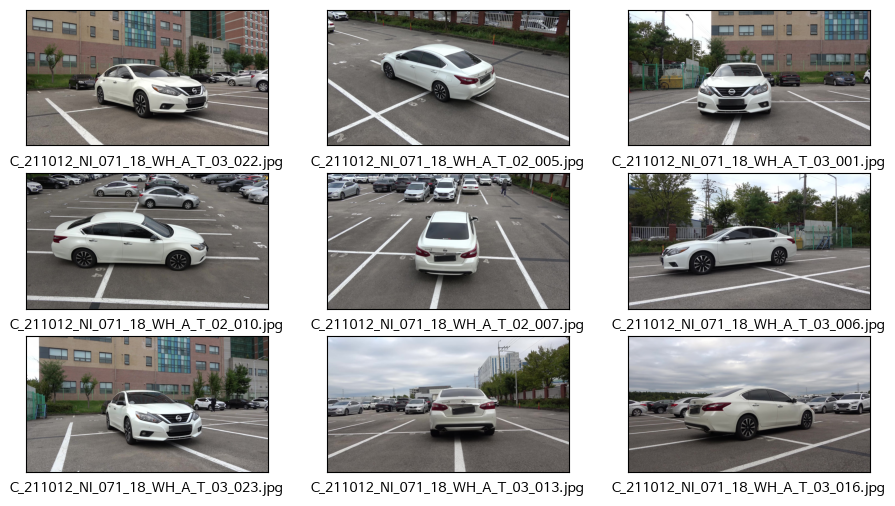

In [8]:
# Show images and labels

plt.figure(figsize=(11,6))
for i in range(9):
    path =train['dir'][i+5] +'/'+ train['image_id'][i] 
    plt.subplot(3,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    
    im_bgr = cv2.imread(path)
    im_rgb = im_bgr[:, :, ::-1]
    plt.imshow(im_rgb, cmap=plt.cm.binary)
    plt.xlabel(train['image_id'][i])
plt.show()

In [5]:
train['label'].value_counts()

벤츠/E-Class/2017       3566
현대/코나/2018            2755
기아/모닝/2017            2721
기아/K3/2019            2563
기아/스포티지/2018          2471
                      ... 
지프/랭글러/2021             91
쉐보레/볼트EV/2017           90
BMW/X3/2020             89
미니/Countryman/2021      79
지프/랭글러/2018             70
Name: label, Length: 370, dtype: int64

In [6]:
train['label'].value_counts().loc[lambda x : x > 900]

벤츠/E-Class/2017    3566
현대/코나/2018         2755
기아/모닝/2017         2721
기아/K3/2019         2563
기아/스포티지/2018       2471
                   ... 
현대/코나/2020          940
쉐보레/스파크/2020        938
현대/스타렉스/2020        937
현대/팰리세이드/2020       935
기아/니로/2019          923
Name: label, Length: 134, dtype: int64

In [7]:
low_data = train['label'].value_counts().loc[lambda x : x < 900].index

low_data = low_data.sort_values()
low_data

# for i, label in enumerate(train['label']):
#     #print(label)
#     if any(j in label for j in low_data) :
#         train.drop(i)
# train['label'].value_counts()

Index(['BMW/3시리즈/2019', 'BMW/3시리즈/2020', 'BMW/5시리즈/2019', 'BMW/5시리즈/2020',
       'BMW/5시리즈/2021', 'BMW/7시리즈/2017', 'BMW/7시리즈/2018', 'BMW/7시리즈/2019',
       'BMW/7시리즈/2020', 'BMW/X3/2017',
       ...
       '현대/코나/2021', '현대/투싼/2021', '현대/포터2/2018', '현대/포터2/2019', '현대/포터2/2020',
       '현대/포터2/2021', '혼다/CR-V/2017', '혼다/CR-V/2021', '혼다/어코드/2017',
       '혼다/어코드/2021'],
      dtype='object', length=236)

In [8]:
# 해당 라벨과 일치하는 인덱스(열) 삭제
for i in range(len(low_data)):
    idx = train[train['label'] == low_data[i]].index
    train.drop(idx, inplace=True)
train.reset_index(inplace=True, drop=True)
train
# idx

,image_id,dir,label
0,C_210813_SS_097_18_BL_A_P_01_031.jpg,../Data/car_dataset/SS_쌍용/097_티볼리/2018_파랑_트림A,쌍용/티볼리/2018
1,C_211217_SS_097_18_BL_A_P_01_057.jpg,../Data/car_dataset/SS_쌍용/097_티볼리/2018_파랑_트림A,쌍용/티볼리/2018
2,C_211217_SS_097_18_BL_A_P_01_011.jpg,../Data/car_dataset/SS_쌍용/097_티볼리/2018_파랑_트림A,쌍용/티볼리/2018
3,C_211217_SS_097_18_BL_A_P_01_065.jpg,../Data/car_dataset/SS_쌍용/097_티볼리/2018_파랑_트림A,쌍용/티볼리/2018
4,C_211217_SS_097_18_BL_A_T_03_013.jpg,../Data/car_dataset/SS_쌍용/097_티볼리/2018_파랑_트림A,쌍용/티볼리/2018
...,...,...,...
206646,C_211116_BE_014_20_BL_A_P_01_007.jpg,../Data/car_dataset/BE_벤츠/014_E-Class/2020_파랑_트림A,벤츠/E-Class/2020
206647,C_211116_BE_014_20_BL_A_P_01_031.jpg,../Data/car_dataset/BE_벤츠/014_E-Class/2020_파랑_트림A,벤츠/E-Class/2020
206648,C_211116_BE_014_20_BL_A_P_01_016.jpg,../Data/car_dataset/BE_벤츠/014_E-Class/2020_파랑_트림A,벤츠/E-Class/2020
206649,C_211116_BE_014_20_BL_A_P_01_045.jpg,../Data/car_dataset/BE_벤츠/014_E-Class/2020_파랑_트림A,벤츠/E-Class/2020


In [9]:
train['label'].value_counts()

벤츠/E-Class/2017    3566
현대/코나/2018         2755
기아/모닝/2017         2721
기아/K3/2019         2563
기아/스포티지/2018       2471
                   ... 
기아/니로/2018          940
쉐보레/스파크/2020        938
현대/스타렉스/2020        937
현대/팰리세이드/2020       935
기아/니로/2019          923
Name: label, Length: 134, dtype: int64

In [10]:
print(len(train.label))

206651


In [11]:
train.label.nunique()

134

In [12]:
label_value = train['label'].values
label_value

array(['쌍용/티볼리/2018', '쌍용/티볼리/2018', '쌍용/티볼리/2018', ...,
       '벤츠/E-Class/2020', '벤츠/E-Class/2020', '벤츠/E-Class/2020'],
      dtype=object)

In [13]:
# 라벨인코더 선언 및 Fitting
le = LabelEncoder()
le.fit(label_value)

# 인코딩한 데이터로 변환
le_encoded = le.transform(label_value)

#결과물을 확인하면 array 형태로 나옵니다.
# 아래는 라벨 인코딩으로 만들어낸 데이터를 데이터 프레임으로 만들어주는 코드입니다.
new_cat = pd.DataFrame(le_encoded, columns = ['result'])
train['label'] = new_cat
train

,image_id,dir,label
0,C_210813_SS_097_18_BL_A_P_01_031.jpg,../Data/car_dataset/SS_쌍용/097_티볼리/2018_파랑_트림A,83
1,C_211217_SS_097_18_BL_A_P_01_057.jpg,../Data/car_dataset/SS_쌍용/097_티볼리/2018_파랑_트림A,83
2,C_211217_SS_097_18_BL_A_P_01_011.jpg,../Data/car_dataset/SS_쌍용/097_티볼리/2018_파랑_트림A,83
3,C_211217_SS_097_18_BL_A_P_01_065.jpg,../Data/car_dataset/SS_쌍용/097_티볼리/2018_파랑_트림A,83
4,C_211217_SS_097_18_BL_A_T_03_013.jpg,../Data/car_dataset/SS_쌍용/097_티볼리/2018_파랑_트림A,83
...,...,...,...
206646,C_211116_BE_014_20_BL_A_P_01_007.jpg,../Data/car_dataset/BE_벤츠/014_E-Class/2020_파랑_트림A,69
206647,C_211116_BE_014_20_BL_A_P_01_031.jpg,../Data/car_dataset/BE_벤츠/014_E-Class/2020_파랑_트림A,69
206648,C_211116_BE_014_20_BL_A_P_01_016.jpg,../Data/car_dataset/BE_벤츠/014_E-Class/2020_파랑_트림A,69
206649,C_211116_BE_014_20_BL_A_P_01_045.jpg,../Data/car_dataset/BE_벤츠/014_E-Class/2020_파랑_트림A,69


In [14]:
le.classes_

array(['BMW/3시리즈/2017', 'BMW/3시리즈/2018', 'BMW/5시리즈/2017', 'BMW/5시리즈/2018',
       '기아/K3/2017', '기아/K3/2018', '기아/K3/2019', '기아/K3/2020',
       '기아/K3/2021', '기아/K5/2017', '기아/K5/2018', '기아/K5/2019',
       '기아/K5/2020', '기아/K7/2017', '기아/K7/2018', '기아/K7/2019',
       '기아/K7/2020', '기아/K9/2019', '기아/K9/2020', '기아/K9/2021',
       '기아/니로/2017', '기아/니로/2018', '기아/니로/2019', '기아/니로/2020',
       '기아/레이/2017', '기아/레이/2018', '기아/레이/2019', '기아/레이/2020',
       '기아/모닝/2017', '기아/모닝/2018', '기아/모닝/2019', '기아/모닝/2020',
       '기아/모닝/2021', '기아/모하비/2017', '기아/모하비/2018', '기아/봉고3/2017',
       '기아/셀토스/2021', '기아/스토닉/2018', '기아/스토닉/2019', '기아/스팅어/2018',
       '기아/스팅어/2019', '기아/스팅어/2020', '기아/스포티지/2017', '기아/스포티지/2018',
       '기아/스포티지/2019', '기아/쏘렌토/2017', '기아/쏘렌토/2018', '기아/쏘렌토/2019',
       '기아/쏘렌토/2020', '기아/쏘렌토/2021', '기아/카니발/2017', '기아/카니발/2018',
       '기아/카니발/2019', '기아/카니발/2020', '랜드로버/레인지로버/2017', '르노삼성/QM3/2017',
       '르노삼성/QM6/2017', '르노삼성/QM6/2018', '르노삼성/QM6/2019', '르노삼성/QM6/2020',

In [18]:
dist.destroy_process_group()

In [15]:
project_name = 'ef_ns04_all_01'
user = 'hojunking'
run_name = 'ef_ns04_all_01'

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: hojunking. Use `wandb login --relogin` to force relogin


Training start with epoch 40 



/home/hojun/miniconda3/envs/torch/lib/python3.10/site-packages/apex/__init__.py:68: DeprecatedFeatureWarning: apex.parallel.DistributedDataParallel is deprecated and will be removed by the end of February 2023.
  warnings.warn(msg, DeprecatedFeatureWarning)
epoch 0 loss: 0.8711: 100%|█████████████| 23894/23894 [1:43:50<00:00,  3.83it/s]


train accuracy = 0.49789
[[1497  636  175 ...    1    3    4]
 [ 520 1877   50 ...    0    2    3]
 [ 181   62 1613 ...    0    0    2]
 ...
 [   2    4    0 ... 1263  628    1]
 [   2    1    1 ...  734 1221    0]
 [   4    4    0 ...    1    2 2344]]


epoch 0 loss: 40.0299: 100%|████████████████| 2584/2584 [06:43<00:00,  6.41it/s]


validation accuracy = 0.60110
[[176  72  13 ...   0   1   0]
 [ 16 179   1 ...   0   0   0]
 [  6   5 343 ...   0   0   0]
 ...
 [  0   0   0 ... 127  15   0]
 [  0   0   0 ...  71 111   0]
 [  0   0   0 ...   0   0 209]]


/home/hojun/miniconda3/envs/torch/lib/python3.10/site-packages/wandb/sdk/data_types/image.py:262: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  util.ensure_matplotlib_figure(data).savefig(buf)
/home/hojun/miniconda3/envs/torch/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


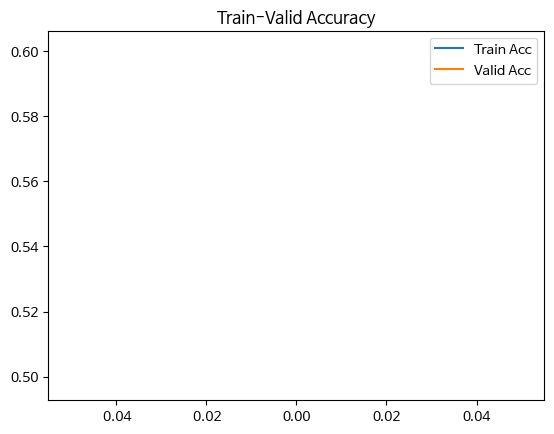

epoch 1 loss: 0.6173: 100%|█████████████| 23894/23894 [1:41:20<00:00,  3.93it/s]


train accuracy = 0.71614
[[2350  310   75 ...    0    0    1]
 [ 288 2470   13 ...    0    0    0]
 [  95   13 2354 ...    0    0    0]
 ...
 [   0    0    0 ... 2052  387    0]
 [   0    0    1 ...  573 1886    0]
 [   0    0    1 ...    0    0 2746]]


epoch 1 loss: 10.1159: 100%|████████████████| 2584/2584 [06:21<00:00,  6.77it/s]


validation accuracy = 0.67620
[[224  33   7 ...   0   0   0]
 [ 25 172   2 ...   0   0   0]
 [ 13   2 329 ...   1   0   0]
 ...
 [  0   0   0 ... 141  21   0]
 [  0   0   0 ...  55 144   0]
 [  0   0   0 ...   0   0 219]]


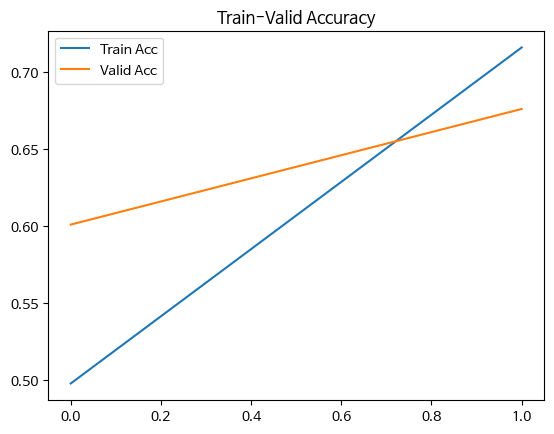

epoch 2 loss: 0.4369: 100%|█████████████| 23894/23894 [1:41:36<00:00,  3.92it/s]


train accuracy = 0.80734
[[2513  199   44 ...    0    0    0]
 [ 186 2605    7 ...    0    1    0]
 [  46    9 2523 ...    0    0    0]
 ...
 [   0    0    0 ... 2386  262    0]
 [   0    0    0 ...  332 2279    0]
 [   1    1    0 ...    0    0 2775]]


epoch 2 loss: 1152.5505: 100%|██████████████| 2584/2584 [06:23<00:00,  6.74it/s]


validation accuracy = 0.73185
[[248  21   1 ...   0   0   0]
 [ 36 166   0 ...   0   0   0]
 [ 34   3 326 ...   0   0   0]
 ...
 [  0   0   0 ... 148  25   0]
 [  0   0   0 ...  34 174   0]
 [  0   0   0 ...   0   0 222]]


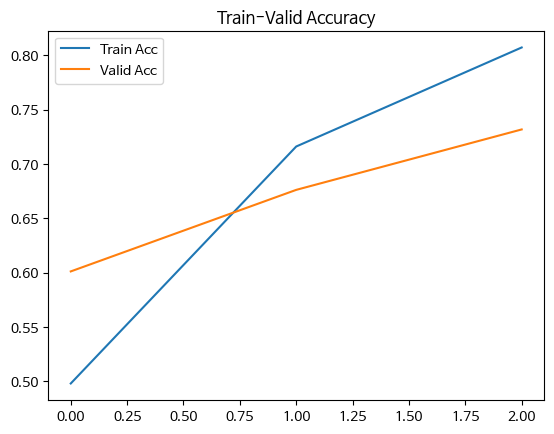

EarlyStopping counter: 1 out of 10
Best valid loss from now: 10.11324748993931


epoch 3 loss: 0.3424: 100%|█████████████| 23894/23894 [1:41:52<00:00,  3.91it/s]


train accuracy = 0.85870
[[2628  126   32 ...    0    0    0]
 [ 120 2678    8 ...    0    0    0]
 [  47    2 2599 ...    1    0    0]
 ...
 [   0    0    0 ... 2552  179    0]
 [   0    0    0 ...  228 2457    0]
 [   0    0    0 ...    0    0 2801]]


epoch 3 loss: 221.7863: 100%|███████████████| 2584/2584 [06:23<00:00,  6.73it/s]


validation accuracy = 0.75261
[[243  20   3 ...   0   0   0]
 [ 20 176   0 ...   0   0   0]
 [ 29   0 307 ...   0   0   0]
 ...
 [  0   0   0 ... 153  14   0]
 [  0   0   0 ...  34 166   0]
 [  0   0   0 ...   0   0 212]]


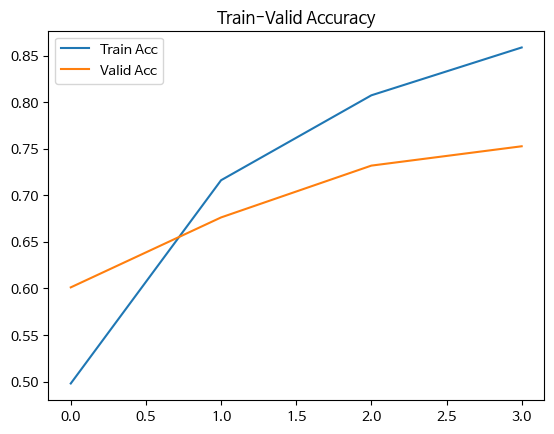

EarlyStopping counter: 2 out of 10
Best valid loss from now: 10.11324748993931


epoch 4 loss: 0.2886: 100%|█████████████| 23894/23894 [1:42:01<00:00,  3.90it/s]


train accuracy = 0.88878
[[2682   75   34 ...    0    0    0]
 [  89 2716    4 ...    0    0    0]
 [  32    5 2650 ...    0    1    0]
 ...
 [   0    0    0 ... 2609  138    0]
 [   0    0    0 ...  174 2555    0]
 [   0    0    0 ...    0    0 2803]]


epoch 4 loss: 322.6784: 100%|███████████████| 2584/2584 [06:25<00:00,  6.70it/s]


validation accuracy = 0.76635
[[256  11   2 ...   0   0   0]
 [ 31 168   0 ...   0   0   0]
 [  9   4 358 ...   0   0   0]
 ...
 [  0   0   0 ... 143  19   0]
 [  0   0   0 ...  28 172   0]
 [  0   0   0 ...   0   0 220]]


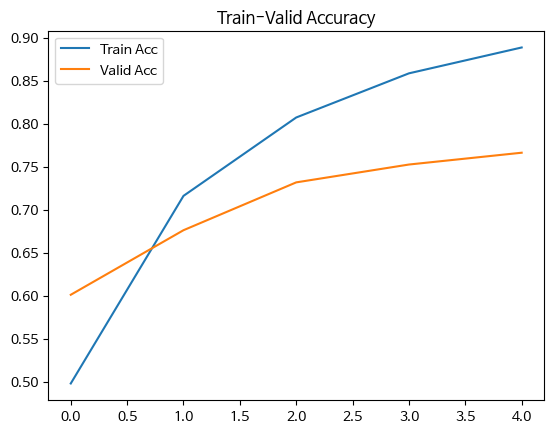

EarlyStopping counter: 3 out of 10
Best valid loss from now: 10.11324748993931


epoch 5 loss: 0.2357: 100%|█████████████| 23894/23894 [1:42:22<00:00,  3.89it/s]


train accuracy = 0.90763
[[2714   75   23 ...    0    0    0]
 [  80 2737    0 ...    0    0    0]
 [  20    4 2690 ...    0    0    0]
 ...
 [   0    0    0 ... 2669  102    0]
 [   0    0    0 ...  126 2614    0]
 [   0    0    0 ...    0    0 2819]]


epoch 5 loss: 374.8801: 100%|███████████████| 2584/2584 [06:26<00:00,  6.68it/s]


validation accuracy = 0.77591
[[227  30   9 ...   0   1   0]
 [ 14 176   0 ...   0   0   0]
 [  5   5 359 ...   0   0   0]
 ...
 [  0   0   0 ... 155  17   0]
 [  0   0   0 ...  36 178   0]
 [  0   0   0 ...   0   0 213]]


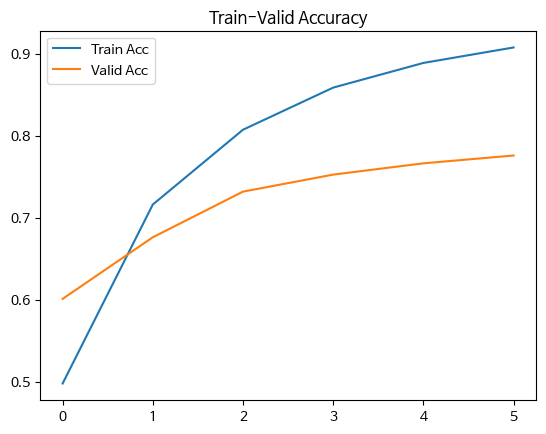

EarlyStopping counter: 4 out of 10
Best valid loss from now: 10.11324748993931


epoch 6 loss: 0.1875: 100%|█████████████| 23894/23894 [1:42:40<00:00,  3.88it/s]


train accuracy = 0.92035
[[2703   73   22 ...    0    0    0]
 [  70 2748    2 ...    0    0    0]
 [  27    5 2705 ...    0    0    0]
 ...
 [   0    0    0 ... 2682  104    0]
 [   0    0    0 ...  119 2637    0]
 [   0    0    0 ...    0    0 2821]]


epoch 6 loss: 20.0483: 100%|████████████████| 2584/2584 [06:28<00:00,  6.66it/s]


validation accuracy = 0.78904
[[249  13   6 ...   0   0   0]
 [ 23 175   1 ...   0   0   0]
 [  9   1 370 ...   0   0   0]
 ...
 [  0   0   0 ... 145  29   0]
 [  0   0   0 ...  17 185   0]
 [  0   0   0 ...   0   0 211]]


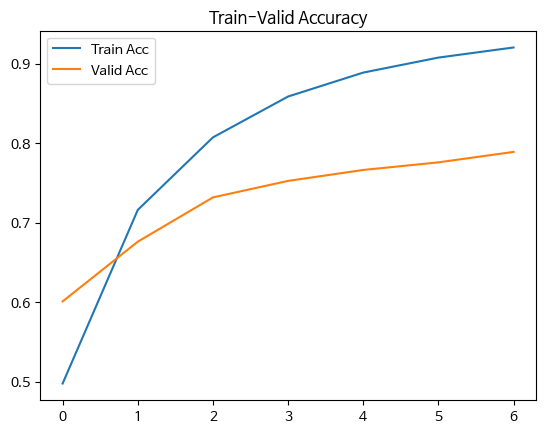

EarlyStopping counter: 5 out of 10
Best valid loss from now: 10.11324748993931


epoch 7 loss: 0.1851: 100%|█████████████| 23894/23894 [1:43:01<00:00,  3.87it/s]


train accuracy = 0.93087
[[2737   58   17 ...    0    0    0]
 [  59 2765    3 ...    0    0    0]
 [  20    5 2727 ...    0    0    0]
 ...
 [   0    0    0 ... 2704   81    0]
 [   0    0    0 ...  100 2673    0]
 [   0    0    0 ...    0    0 2820]]


epoch 7 loss: 16.7362: 100%|████████████████| 2584/2584 [06:29<00:00,  6.64it/s]


validation accuracy = 0.79127
[[265   6   2 ...   0   0   0]
 [ 42 155   1 ...   0   0   0]
 [ 18   2 355 ...   0   0   0]
 ...
 [  0   0   0 ... 162  14   0]
 [  0   0   0 ...  23 192   0]
 [  0   0   0 ...   0   0 210]]


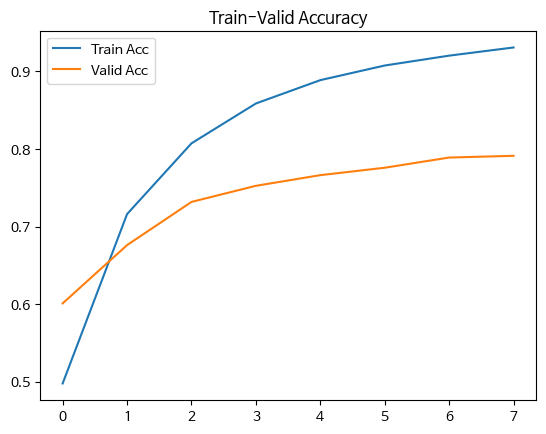

EarlyStopping counter: 6 out of 10
Best valid loss from now: 10.11324748993931


epoch 8 loss: 0.1691: 100%|█████████████| 23894/23894 [1:42:43<00:00,  3.88it/s]


train accuracy = 0.93797
[[2743   57   20 ...    0    0    0]
 [  56 2763    2 ...    0    0    0]
 [  19    5 2713 ...    0    0    0]
 ...
 [   0    0    0 ... 2730   81    0]
 [   0    0    0 ...   94 2700    0]
 [   0    0    0 ...    0    1 2816]]


epoch 8 loss: 0.8766: 100%|█████████████████| 2584/2584 [06:29<00:00,  6.64it/s]


validation accuracy = 0.79563
[[247  22   2 ...   0   0   0]
 [ 17 185   1 ...   0   0   0]
 [ 14   2 353 ...   0   0   0]
 ...
 [  0   0   0 ... 155  11   0]
 [  0   0   0 ...  28 180   0]
 [  0   0   0 ...   0   0 212]]


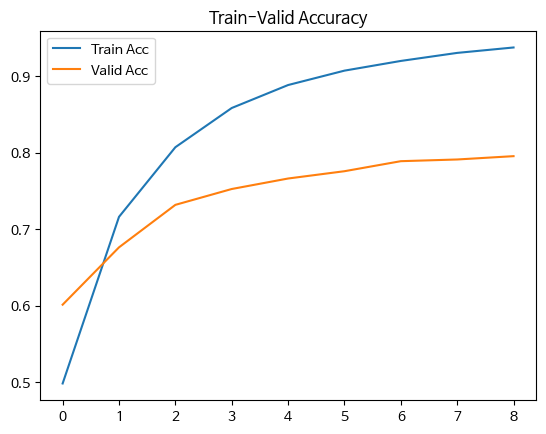

epoch 9 loss: 0.1647: 100%|█████████████| 23894/23894 [1:43:02<00:00,  3.86it/s]


train accuracy = 0.94368
[[2757   45   16 ...    0    0    0]
 [  48 2782    3 ...    0    0    0]
 [  21    2 2730 ...    0    0    0]
 ...
 [   0    0    0 ... 2743   70    0]
 [   0    0    0 ...   66 2720    1]
 [   0    0    0 ...    1    1 2825]]


epoch 9 loss: 11.6978: 100%|████████████████| 2584/2584 [06:30<00:00,  6.61it/s]


validation accuracy = 0.80499
[[252  10   7 ...   0   1   0]
 [ 21 172   2 ...   0   0   0]
 [  5   1 384 ...   0   0   0]
 ...
 [  0   0   0 ... 157  12   0]
 [  0   0   0 ...  19 189   0]
 [  0   0   0 ...   0   0 218]]


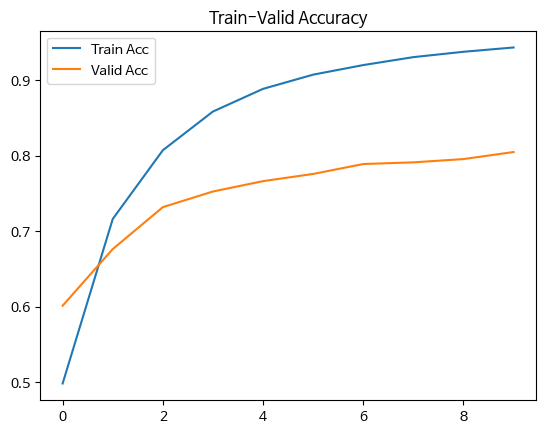

EarlyStopping counter: 1 out of 10
Best valid loss from now: 0.8771397001353972


epoch 10 loss: 0.1429: 100%|████████████| 23894/23894 [1:43:14<00:00,  3.86it/s]


train accuracy = 0.94803
[[2762   32   18 ...    0    0    0]
 [  36 2797    1 ...    0    0    0]
 [  20    4 2748 ...    0    0    0]
 ...
 [   0    0    0 ... 2749   69    0]
 [   0    0    0 ...   76 2724    0]
 [   0    0    0 ...    0    0 2823]]


epoch 10 loss: 0.8218: 100%|████████████████| 2584/2584 [06:32<00:00,  6.58it/s]


validation accuracy = 0.81092
[[253  12   5 ...   0   0   0]
 [ 19 172   0 ...   0   0   0]
 [  7   0 353 ...   1   0   1]
 ...
 [  0   0   0 ... 166   6   0]
 [  0   0   0 ...  34 176   0]
 [  0   0   0 ...   0   2 212]]


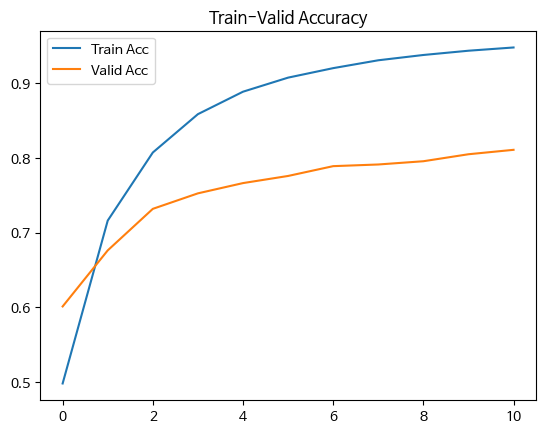

epoch 11 loss: 0.1193: 100%|████████████| 23894/23894 [1:43:31<00:00,  3.85it/s]


train accuracy = 0.95262
[[2768   38   17 ...    0    0    0]
 [  37 2790    3 ...    0    0    0]
 [  12    5 2748 ...    0    0    0]
 ...
 [   0    0    0 ... 2744   60    0]
 [   0    0    0 ...   64 2741    1]
 [   0    0    0 ...    0    0 2830]]


epoch 11 loss: 0.8630: 100%|████████████████| 2584/2584 [06:33<00:00,  6.56it/s]


validation accuracy = 0.81043
[[250  14   5 ...   0   0   0]
 [ 23 175   0 ...   0   0   0]
 [ 17   2 364 ...   0   0   0]
 ...
 [  0   0   0 ... 155  12   0]
 [  0   0   0 ...  24 184   0]
 [  0   0   0 ...   0   0 215]]


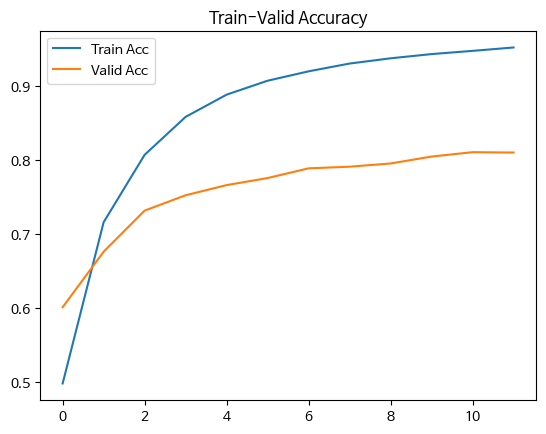

EarlyStopping counter: 1 out of 10
Best valid loss from now: 0.8224009678075549


epoch 12 loss: 0.1215: 100%|████████████| 23894/23894 [1:43:50<00:00,  3.83it/s]


train accuracy = 0.95516
[[2763   37   17 ...    0    0    0]
 [  39 2799    1 ...    0    0    0]
 [  26    3 2746 ...    0    1    0]
 ...
 [   0    0    0 ... 2746   64    0]
 [   0    0    0 ...   71 2740    0]
 [   0    0    0 ...    0    0 2833]]


epoch 12 loss: 0.8749: 100%|████████████████| 2584/2584 [06:36<00:00,  6.52it/s]


validation accuracy = 0.81031
[[248  15   2 ...   0   0   0]
 [ 16 174   1 ...   0   0   0]
 [ 10   2 337 ...   1   0   0]
 ...
 [  0   0   0 ... 171   4   0]
 [  0   0   0 ...  31 178   0]
 [  0   0   0 ...   0   0 217]]


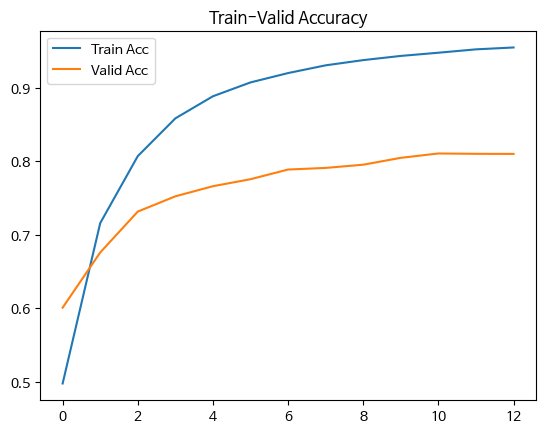

EarlyStopping counter: 2 out of 10
Best valid loss from now: 0.8224009678075549


epoch 13 loss: 0.1135: 100%|████████████| 23894/23894 [1:44:08<00:00,  3.82it/s]


train accuracy = 0.95852
[[2780   37    8 ...    0    0    0]
 [  35 2799    0 ...    0    0    0]
 [  10    5 2765 ...    0    0    0]
 ...
 [   0    0    0 ... 2771   43    0]
 [   0    0    0 ...   54 2752    0]
 [   0    0    0 ...    0    0 2835]]


epoch 13 loss: 0.8556: 100%|████████████████| 2584/2584 [06:35<00:00,  6.54it/s]


validation accuracy = 0.81622
[[267   3   1 ...   0   0   0]
 [ 30 167   1 ...   0   0   0]
 [ 19   0 367 ...   0   0   0]
 ...
 [  0   0   0 ... 169   4   0]
 [  0   0   0 ...  34 174   0]
 [  0   0   0 ...   0   0 219]]


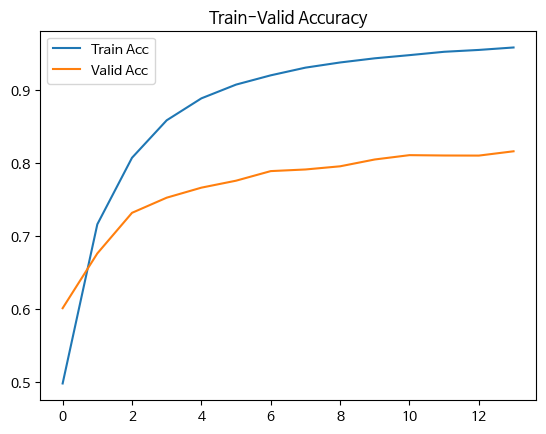

EarlyStopping counter: 3 out of 10
Best valid loss from now: 0.8224009678075549


epoch 14 loss: 0.1131: 100%|████████████| 23894/23894 [1:44:25<00:00,  3.81it/s]


train accuracy = 0.96116
[[2786   29   20 ...    0    0    0]
 [  28 2802    0 ...    0    0    0]
 [  14    0 2775 ...    0    0    0]
 ...
 [   0    0    0 ... 2770   51    0]
 [   0    0    0 ...   49 2764    0]
 [   0    0    0 ...    0    0 2843]]


epoch 14 loss: 0.8581: 100%|████████████████| 2584/2584 [06:37<00:00,  6.51it/s]


validation accuracy = 0.81641
[[240  24   2 ...   0   0   0]
 [ 11 191   0 ...   0   0   0]
 [ 10   2 375 ...   0   0   0]
 ...
 [  0   0   0 ... 155  15   0]
 [  0   0   0 ...  21 191   0]
 [  0   0   0 ...   0   0 213]]


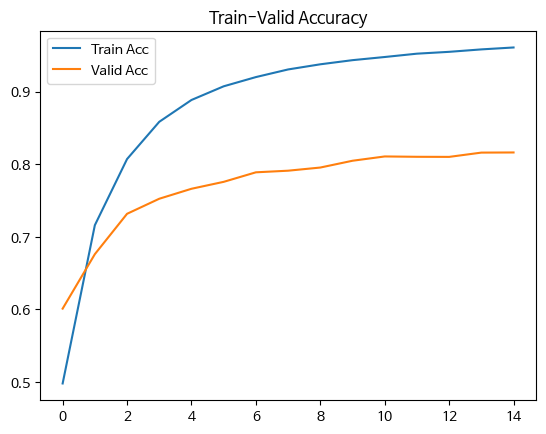

EarlyStopping counter: 4 out of 10
Best valid loss from now: 0.8224009678075549


epoch 15 loss: 0.1063: 100%|████████████| 23894/23894 [1:44:37<00:00,  3.81it/s]


train accuracy = 0.96374
[[2798   27   13 ...    0    0    0]
 [  29 2810    0 ...    0    0    0]
 [  12    3 2782 ...    1    0    0]
 ...
 [   1    0    0 ... 2767   54    0]
 [   0    0    0 ...   57 2768    0]
 [   0    0    0 ...    0    0 2832]]


epoch 15 loss: 0.9220: 100%|████████████████| 2584/2584 [06:35<00:00,  6.53it/s]


validation accuracy = 0.81239
[[254  15   1 ...   0   0   0]
 [ 13 182   0 ...   0   0   0]
 [ 15   3 361 ...   0   0   0]
 ...
 [  0   0   0 ... 141  16   0]
 [  0   0   0 ...  11 203   0]
 [  0   0   0 ...   0   0 213]]


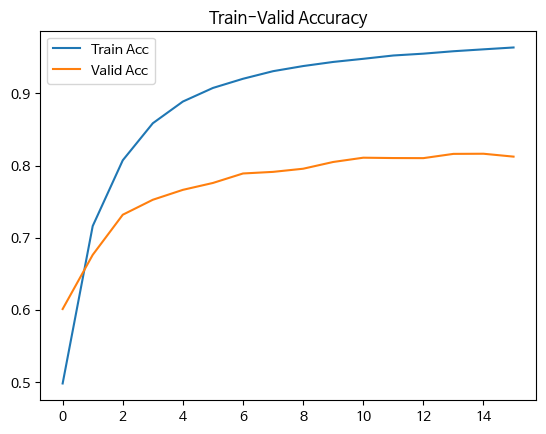

EarlyStopping counter: 5 out of 10
Best valid loss from now: 0.8224009678075549


epoch 16 loss: 0.0912: 100%|████████████| 23894/23894 [1:44:56<00:00,  3.79it/s]


train accuracy = 0.96540
[[2778   29   14 ...    0    0    0]
 [  25 2813    1 ...    0    0    0]
 [  15    3 2772 ...    0    0    0]
 ...
 [   0    0    0 ... 2772   51    0]
 [   0    0    0 ...   60 2762    0]
 [   0    0    0 ...    0    0 2835]]


epoch 16 loss: 0.9059: 100%|████████████████| 2584/2584 [06:35<00:00,  6.53it/s]


validation accuracy = 0.81786
[[242  27   2 ...   0   0   0]
 [ 14 184   0 ...   0   0   0]
 [ 23   2 357 ...   0   0   0]
 ...
 [  0   0   0 ... 161  13   0]
 [  0   0   0 ...  18 191   0]
 [  0   0   0 ...   0   0 219]]


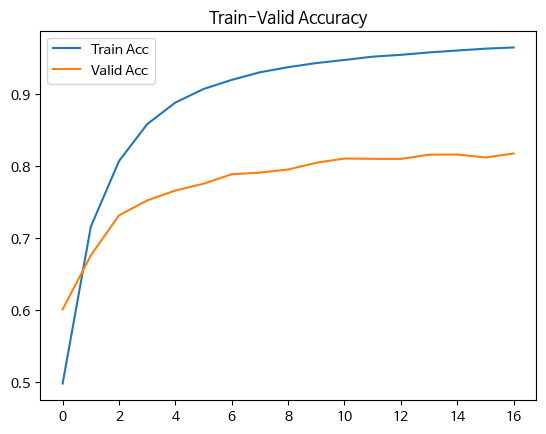

EarlyStopping counter: 6 out of 10
Best valid loss from now: 0.8224009678075549


epoch 17 loss: 0.0862: 100%|████████████| 23894/23894 [1:45:20<00:00,  3.78it/s]


train accuracy = 0.96701
[[2791   24    8 ...    0    0    0]
 [  23 2813    4 ...    0    0    0]
 [  13    1 2778 ...    0    0    0]
 ...
 [   0    0    0 ... 2787   42    0]
 [   0    0    0 ...   47 2767    0]
 [   0    0    0 ...    0    0 2832]]


epoch 17 loss: 0.8803: 100%|████████████████| 2584/2584 [06:37<00:00,  6.51it/s]


validation accuracy = 0.82130
[[254  12   2 ...   0   0   0]
 [ 21 176   1 ...   0   0   0]
 [  7   1 373 ...   0   0   0]
 ...
 [  0   0   0 ... 156  16   0]
 [  0   0   0 ...  15 195   0]
 [  0   0   0 ...   0   0 216]]


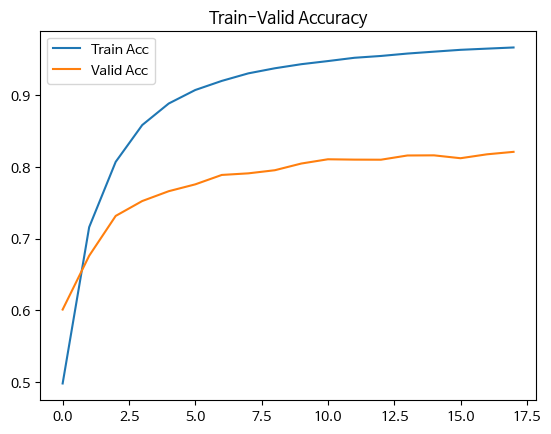

EarlyStopping counter: 7 out of 10
Best valid loss from now: 0.8224009678075549


epoch 18 loss: 0.0843: 100%|████████████| 23894/23894 [1:45:33<00:00,  3.77it/s]


train accuracy = 0.96875
[[2791   22   15 ...    0    0    0]
 [  23 2808    0 ...    0    0    0]
 [  20    1 2776 ...    0    0    0]
 ...
 [   0    0    0 ... 2779   44    0]
 [   0    0    0 ...   51 2768    0]
 [   0    0    0 ...    0    0 2831]]


epoch 18 loss: 0.9305: 100%|████████████████| 2584/2584 [06:36<00:00,  6.51it/s]


validation accuracy = 0.81999
[[245  22   1 ...   0   0   0]
 [ 15 182   0 ...   0   0   0]
 [ 10   1 375 ...   0   0   0]
 ...
 [  0   0   0 ... 159  14   0]
 [  0   0   0 ...  21 189   0]
 [  0   0   0 ...   1   0 218]]


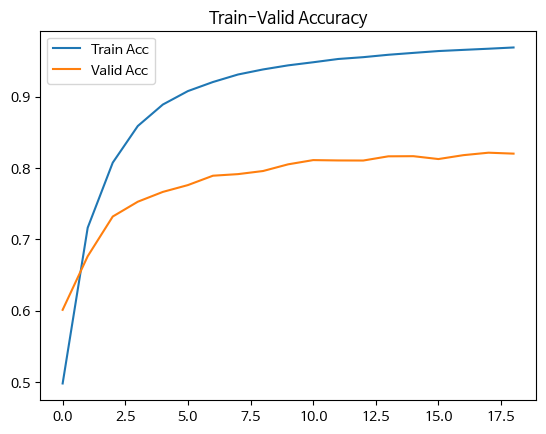

EarlyStopping counter: 8 out of 10
Best valid loss from now: 0.8224009678075549


epoch 19 loss: 0.0810: 100%|████████████| 23894/23894 [1:45:52<00:00,  3.76it/s]


train accuracy = 0.96976
[[2789   33    7 ...    0    0    0]
 [  31 2808    2 ...    0    0    0]
 [  10    1 2783 ...    0    0    0]
 ...
 [   0    0    0 ... 2789   36    0]
 [   0    0    0 ...   39 2782    0]
 [   0    0    0 ...    0    0 2835]]


epoch 19 loss: 0.8999: 100%|████████████████| 2584/2584 [06:35<00:00,  6.53it/s]


validation accuracy = 0.82464
[[250  10   3 ...   0   0   0]
 [ 22 176   1 ...   0   0   0]
 [  6   3 355 ...   0   0   0]
 ...
 [  0   0   0 ... 166   9   0]
 [  0   0   0 ...  15 194   0]
 [  0   0   0 ...   0   0 220]]


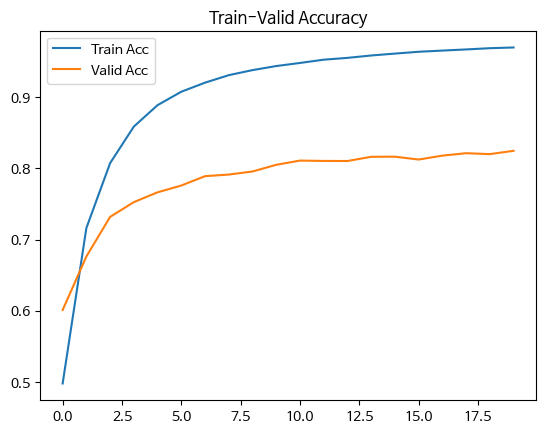

EarlyStopping counter: 9 out of 10
Best valid loss from now: 0.8224009678075549


epoch 20 loss: 0.0906: 100%|████████████| 23894/23894 [1:46:11<00:00,  3.75it/s]


train accuracy = 0.97106
[[2804   15   11 ...    0    0    0]
 [  13 2819    1 ...    0    0    0]
 [  11    4 2781 ...    0    0    0]
 ...
 [   0    0    0 ... 2795   36    0]
 [   0    0    0 ...   38 2781    0]
 [   0    0    0 ...    0    0 2839]]


epoch 20 loss: 0.9759: 100%|████████████████| 2584/2584 [06:36<00:00,  6.52it/s]


validation accuracy = 0.81890
[[250  17   3 ...   0   0   0]
 [ 27 170   0 ...   0   0   0]
 [  8   0 373 ...   0   0   0]
 ...
 [  0   0   0 ... 157   8   0]
 [  0   0   0 ...  29 170   0]
 [  0   0   0 ...   0   1 216]]


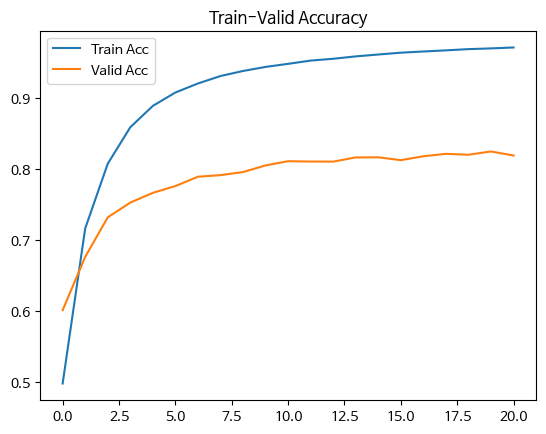

EarlyStopping counter: 10 out of 10
Best valid loss from now: 0.8224009678075549
stop called
time : 1 day, 14:33:59
Best Epoch : 19/ 21
Best Train Accuracy : 0.96976
[[2789   33    7 ...    0    0    0]
 [  31 2808    2 ...    0    0    0]
 [  10    1 2783 ...    0    0    0]
 ...
 [   0    0    0 ... 2789   36    0]
 [   0    0    0 ...   39 2782    0]
 [   0    0    0 ...    0    0 2835]]
Best Valid Accuracy : 0.82464
[[250  10   3 ...   0   0   0]
 [ 22 176   1 ...   0   0   0]
 [  6   3 355 ...   0   0   0]
 ...
 [  0   0   0 ... 166   9   0]
 [  0   0   0 ...  15 194   0]
 [  0   0   0 ...   0   0 220]]


In [16]:
%run classification_train_efficientnet2.ipynb

In [18]:
print(f'Best Epoch : {best_index}/ {len(valid_acc_list)}')
print(f'Best Train Accuracy : {train_acc_list[best_index]:.5f}')
print(train_matrix_list[best_index])
print(f'Best Valid Accuracy : {valid_acc_list[best_index]:.5f}')
print(valid_matrix_list[best_index])

Best Epoch : 38/ 40
Best Train Accuracy : 0.99712
[[2847    3    1 ...    0    0    0]
 [   4 2849    0 ...    0    0    0]
 [   3    1 2843 ...    0    0    0]
 ...
 [   0    0    0 ... 2848    3    0]
 [   0    0    0 ...    2 2849    0]
 [   0    0    0 ...    0    0 2852]]
Best Valid Accuracy : 0.88483
[[255  10   2 ...   0   0   0]
 [  6 196   0 ...   0   0   0]
 [  3   0 389 ...   0   0   0]
 ...
 [  0   0   0 ... 178   5   0]
 [  0   0   0 ...  12 208   0]
 [  0   0   0 ...   0   0 218]]


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: honbul. Use `wandb login --relogin` to force relogin


/home/super/endo_venv/lib/python3.8/site-packages/albumentations/augmentations/dropout/cutout.py:50: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(
epoch 0 loss: 0.0238: 100%|█████████████████████████████████████████████████████████| 3000/3000 [10:26<00:00,  4.79it/s]


train accuracy = 0.98053
[[14778   222]
 [  362 14638]]


epoch 0 loss: 0.5145: 100%|█████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 20.92it/s]


validation accuracy = 0.81408
[[512 127]
 [  5  66]]


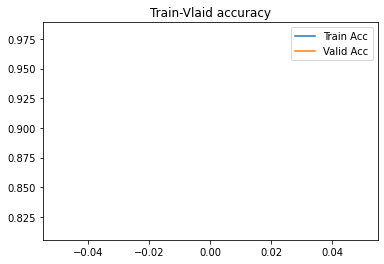

epoch 1 loss: 0.0124: 100%|█████████████████████████████████████████████████████████| 3000/3000 [10:25<00:00,  4.79it/s]


train accuracy = 0.99637
[[14946    54]
 [   55 14945]]


epoch 1 loss: 0.7367: 100%|█████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 21.10it/s]


validation accuracy = 0.70704
[[431 208]
 [  0  71]]


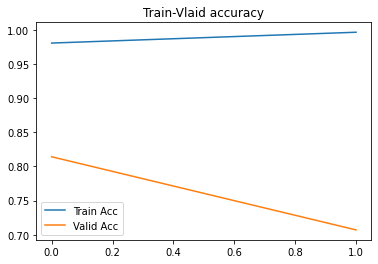

epoch 2 loss: 0.0020: 100%|█████████████████████████████████████████████████████████| 3000/3000 [10:30<00:00,  4.76it/s]


train accuracy = 0.99767
[[14959    41]
 [   29 14971]]


epoch 2 loss: 0.6676: 100%|█████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 21.18it/s]


validation accuracy = 0.80563
[[509 130]
 [  8  63]]


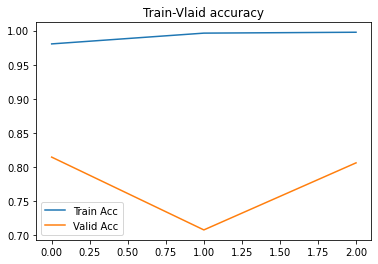

epoch 3 loss: 0.0028: 100%|█████████████████████████████████████████████████████████| 3000/3000 [10:31<00:00,  4.75it/s]


train accuracy = 0.99870
[[14980    20]
 [   19 14981]]


epoch 3 loss: 0.3945: 100%|█████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 20.96it/s]


validation accuracy = 0.85915
[[546  93]
 [  7  64]]


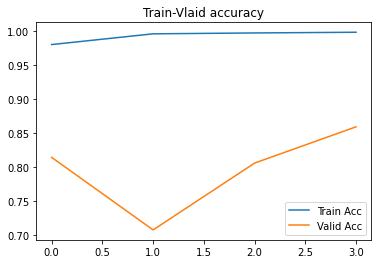

epoch 4 loss: 0.0052: 100%|█████████████████████████████████████████████████████████| 3000/3000 [10:32<00:00,  4.74it/s]


train accuracy = 0.99773
[[14961    39]
 [   29 14971]]


epoch 4 loss: 0.3124: 100%|█████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 21.07it/s]


validation accuracy = 0.88169
[[569  70]
 [ 14  57]]


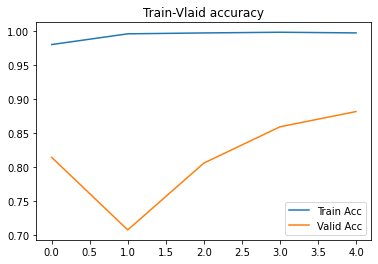

epoch 5 loss: 0.0049:  47%|██████████████████████████▊                              | 1413/3000 [04:58<05:23,  4.90it/s]

In [ ]:
%run classification_train_val_separate_efficientnet.ipynb